/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_51433/2612859008.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  facecolors=cm.get_cmap(cmap)(norm(field)),


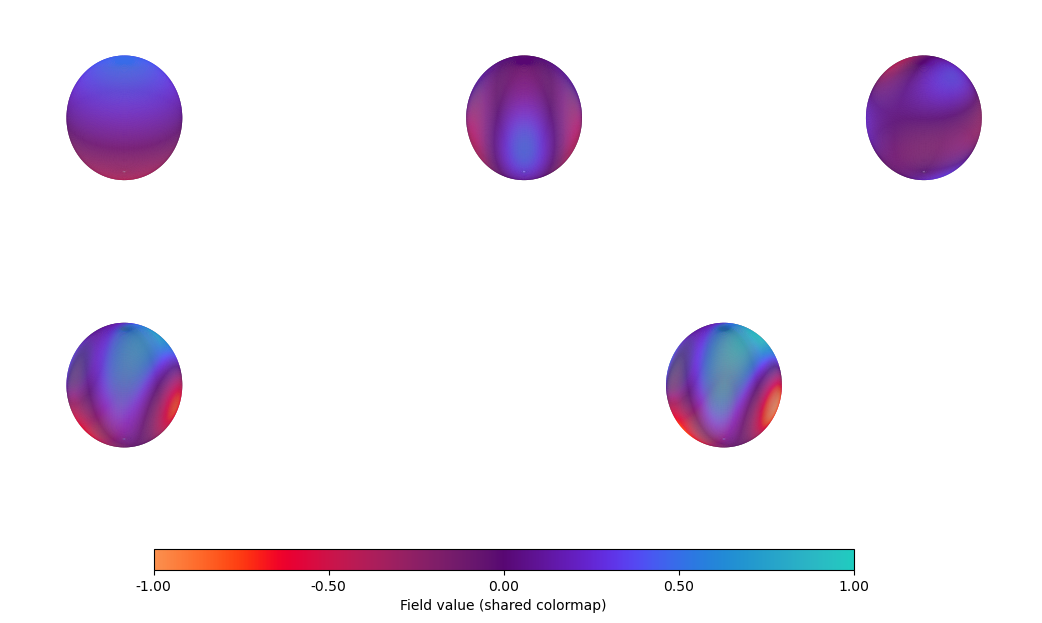

In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.special import gammaln
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmasher as cmr

# ---------- math: associated Legendre & real Y_lm (Condon–Shortley) ----------

def _double_factorial_odd(m: int):
    if m == 0:
        return 1.0
    m_f = float(m)
    return jnp.exp(gammaln(2.0*m_f + 1.0) - m_f*jnp.log(2.0) - gammaln(m_f + 1.0))

def _P_lm(l: int, m: int, x):
    mabs = int(abs(m))
    Pmm = ((-1.0)**mabs) * _double_factorial_odd(mabs) * (1.0 - x*x)**(0.5*mabs)
    if l == mabs:
        return Pmm
    Pm1m = x*(2*mabs + 1.0)*Pmm
    if l == mabs + 1:
        return Pm1m
    P_lm_prev2 = Pmm
    P_lm_prev1 = Pm1m
    for ell in range(mabs + 2, l + 1):
        ell_f = float(ell)
        P_lm_curr = ((2.0*ell_f - 1.0)*x*P_lm_prev1 - (ell_f + mabs - 1.0)*P_lm_prev2) / (ell_f - mabs)
        P_lm_prev2, P_lm_prev1 = P_lm_prev1, P_lm_curr
    return P_lm_prev1

def real_sph_harm(l: int, m: int, theta, phi):
    mabs = abs(m)
    x = jnp.cos(theta)
    Plm = _P_lm(l, mabs, x)
    l_f = float(l)
    m_f = float(mabs)
    Nlm = jnp.sqrt((2.0*l_f + 1.0)/(4.0*jnp.pi) *
                   jnp.exp(gammaln(l_f - m_f + 1.0) - gammaln(l_f + m_f + 1.0)))
    base = Nlm * Plm
    if m > 0:
        return jnp.sqrt(2.0) * base * jnp.cos(m * phi)
    elif m < 0:
        return jnp.sqrt(2.0) * base * jnp.sin(mabs * phi)
    else:
        return base

# ---------- rendering helpers ----------

def sphere_xyz(theta, phi, r=1.0):
    X = r * jnp.sin(theta) * jnp.cos(phi)
    Y = r * jnp.sin(theta) * jnp.sin(phi)
    Z = r * jnp.cos(theta)
    return X, Y, Z

from matplotlib import cm
from matplotlib.colors import Normalize

def plot_field_on_sphere(ax, field, theta, phi, cmap="cmr.redshift",
                         vmin=None, vmax=None, add_colorbar=False, norm=None, sm=None):
    X = jnp.sin(theta) * jnp.cos(phi)
    Y = jnp.sin(theta) * jnp.sin(phi)
    Z = jnp.cos(theta)

    field = np.array(field)
    # Use the provided norm and sm for consistent color mapping
    if norm is None:
        norm = Normalize(vmin=np.nanmin(field), vmax=np.nanmax(field))
    if sm is None:
        sm = cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])

    ax.plot_surface(np.array(X), np.array(Y), np.array(Z),
                    rstride=1, cstride=1,
                    facecolors=cm.get_cmap(cmap)(norm(field)),
                    linewidth=0, antialiased=True, shade=False)

    # no grid/labels
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_box_aspect((1, 1, 1))
    ax.set_axis_off()

    # Only add colorbar if requested (handled outside for global colorbar)
    if add_colorbar and sm is not None:
        cb = ax.figure.colorbar(sm, ax=ax, pad=0.04, fraction=0.05, shrink=0.9)
        cb.set_label("Field value (shared colormap)")

def rescale_to_unit(field):
    a = jnp.max(jnp.abs(field))
    return jnp.where(a > 0, field / a, field)

# ---------- choose components ----------
components = [
    (1, 0, 1.0),
    (3, 3, 0.8),
    (3, 1, -0.6),
]

# ---------- grid ----------
n_th, n_ph = 300, 600
theta = jnp.linspace(0.0, jnp.pi, n_th)
phi   = jnp.linspace(0.0, 2.0*jnp.pi, n_ph)
TH, PH = jnp.meshgrid(theta, phi, indexing="ij")

fields = []
for (l, m, a) in components:
    Y = real_sph_harm(l, m, TH, PH)
    fields.append(a * Y)

sum_field = jnp.sum(jnp.stack(fields, axis=0), axis=0)
sum_rescaled = rescale_to_unit(sum_field)

# ---------- figure ----------
plt.figure(figsize=(14, 7))

# Compute global vmin/vmax for all fields (including rescaled)
all_fields = fields + [sum_field, sum_rescaled]
global_vmin = float(np.nanmin([np.nanmin(np.array(f)) for f in all_fields]))
global_vmax = float(np.nanmax([np.nanmax(np.array(f)) for f in all_fields]))
norm = Normalize(vmin=global_vmin, vmax=global_vmax)
cmap = "cmr.guppy"
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

# top row: components (no normalization, just raw values)
n_comp = len(fields)
for i, F in enumerate(fields, 1):
    ax = plt.subplot2grid((2, n_comp), (0, i-1), projection='3d')
    plot_field_on_sphere(ax, F, TH, PH, cmap=cmap, norm=norm, sm=sm, add_colorbar=False)

# bottom row: sum and rescaled sum (show both, with same colormap)
ax_sum = plt.subplot2grid((2, n_comp), (1, 0), colspan=n_comp//2, projection='3d')
plot_field_on_sphere(ax_sum, sum_field, TH, PH, cmap=cmap, norm=norm, sm=sm, add_colorbar=False)

ax_resc = plt.subplot2grid((2, n_comp), (1, n_comp//2), colspan=n_comp - n_comp//2, projection='3d')
plot_field_on_sphere(ax_resc, sum_rescaled, TH, PH, cmap=cmap, norm=norm, sm=sm, add_colorbar=False)

# Add a single colorbar for all axes, below the plots
fig = plt.gcf()
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.03])  # [left, bottom, width, height]
cb = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cb.set_label("Field value (shared colormap)")

# Set colorbar ticks to include -1, 0, 1 and some reasonable intermediates
# Use the actual vmin/vmax, but always include -1, 0, 1 if within range
ticks = np.array([-1.0, -0.5, 0.0, 0.5, 1.0])
cb.set_ticks(ticks)
cb.set_ticklabels([f"{t:.2f}" for t in ticks])


plt.subplots_adjust(wspace=0.4, hspace=0.2, bottom=0.18)
#plt.show()
plt.savefig("pulsation_stacking.svg")
plt.show()

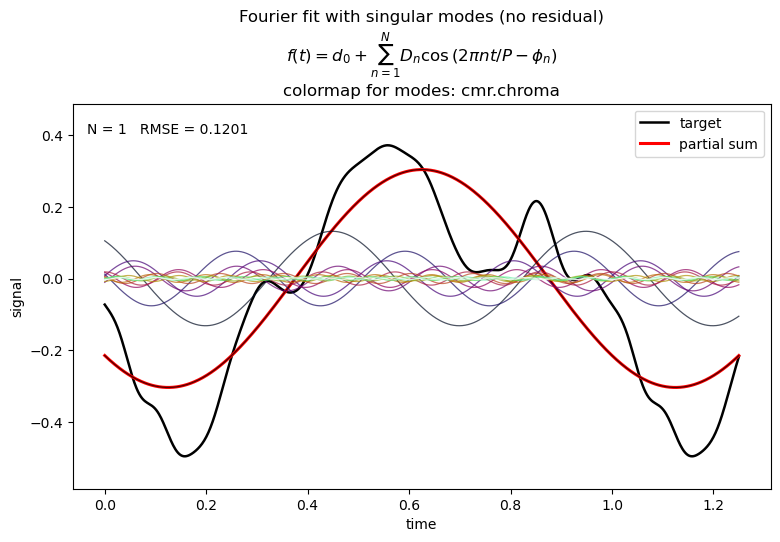

In [2]:
# Rebuild animation with NO residual line.
# - target: black
# - fit (partial sum): red
# - singular modes: cmr.chroma (fallback to plasma if cmasher is unavailable)
# - legend includes only target & partial sum.
#
# Output: /mnt/data/fourier_fit_modes_cmr_chroma_blackred_nores.gif

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

try:
    import cmasher as cmr
    cmap = cmr.chroma
    cmap_name_used = "cmr.chroma"
except Exception:
    cmap = plt.get_cmap("plasma")
    cmap_name_used = "plasma (fallback, install `cmasher` for cmr.chroma)"

P = 1.0
N_true = 15
d0_true = 0.0

rng = np.random.default_rng(7)
D_true = 0.35 * (1 / np.arange(1, N_true+1)) * np.exp(-np.arange(1, N_true+1)/7)
PHI_true = rng.uniform(0, 2*np.pi, size=N_true)

T = np.linspace(0, 1.25*P, 900)

def fourier_series(P, d0, D, PHI, t):
    n = np.arange(1, len(D)+1)
    return d0 + np.sum(D * np.cos(2*np.pi*n*t/P - PHI))

def mode_term(P, Dn, PHIn, n, t):
    return Dn * np.cos(2*np.pi*n*t/P - PHIn)

# Build target and components
f_true = np.array([fourier_series(P, d0_true, D_true, PHI_true, t) for t in T])
modes = np.array([[mode_term(P, D_true[n-1], PHI_true[n-1], n, t) for t in T] for n in range(1, N_true+1)])
partial_sums = np.cumsum(modes, axis=0) + d0_true

fig, ax = plt.subplots(figsize=(9,5))

# Requested colors
line_true, = ax.plot(T, f_true, lw=1.8, color="black", label="target")
line_fit,  = ax.plot(T, partial_sums[0], lw=2.2, color="red", label="partial sum")

# Mode lines (no legend)
colors = [cmap(i/(N_true-1)) for i in range(N_true)]
mode_lines = []
for n in range(N_true):
    ln, = ax.plot(T, modes[n], lw=0.9, alpha=0.7, color=colors[n])
    mode_lines.append(ln)

ax.set_title("Fourier fit with singular modes (no residual)\n"
             + r"$f(t) = d_0 + \sum_{n=1}^{N} D_n \cos\left(2\pi n t / P - \phi_n\right)$"
             + f"\ncolormap for modes: {cmap_name_used}")
ax.set_xlabel("time")
ax.set_ylabel("signal")

# Stable y-limits
ymin = min(f_true.min(), partial_sums.min(), modes.sum(axis=0).min())
ymax = max(f_true.max(), partial_sums.max(), modes.sum(axis=0).max())
pad = 0.08 * (ymax - ymin + 1e-12)
ax.set_ylim(ymin - pad, ymax + pad)

# Legend: only target & partial sum
ax.legend(loc="best", frameon=True)

# Annotation with N and RMSE
rmse0 = np.sqrt(np.mean((f_true - partial_sums[0])**2))
txt = ax.text(0.02, 0.95, f"N = 1   RMSE = {rmse0:.4f}", transform=ax.transAxes, va="top")

def update(frame_idx):
    N = frame_idx + 1
    fN = partial_sums[frame_idx]
    line_fit.set_ydata(fN)
    for j, ln in enumerate(mode_lines):
        if j <= frame_idx:
            ln.set_visible(True)
            if j == frame_idx:
                ln.set_linewidth(2.0)
                ln.set_alpha(0.95)
            else:
                ln.set_linewidth(0.9)
                ln.set_alpha(0.7)
        else:
            ln.set_visible(False)
    rmse = np.sqrt(np.mean((f_true - fN)**2))
    txt.set_text(f"N = {N}   RMSE = {rmse:.4f}")
    return [line_fit, txt] + mode_lines

# ani = animation.FuncAnimation(fig, update, frames=N_true, interval=240, blit=False)

# out_path = "/mnt/data/fourier_fit_modes_cmr_chroma_blackred_nores.gif"
# from matplotlib.animation import PillowWriter
# ani.save(out_path, writer=PillowWriter(fps=5))

# out_pat